In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
# import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [36]:
classeses = []
for i in os.listdir('C:/Users/Admin/Desktop/MIE1517_Project/data2'):
    if i!=5:
        classeses.append(i)
classeses

['fear', 'happiness', 'neutrality', 'sadness', 'surprise']

In [3]:
import os
from torchvision import transforms
from PIL import Image
from collections import Counter

# Define the path to your dataset
data_dir = 'C:/Users/Admin/Desktop/MIE1517_Project/data'

# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Flip with a probability of 1 (always flip)
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

# Function to count images in each directory
def count_images(data_dir):
    counts = Counter()
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            counts[class_dir] = len(os.listdir(class_path))
    return counts

# Function to augment images to match the max count
def augment_to_match_max(data_dir, max_count):
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        image_files = os.listdir(class_path)
        num_images = len(image_files)
        num_to_augment = max_count - num_images

        for i in range(num_to_augment):
            img_path = os.path.join(class_path, image_files[i % num_images])
            img = Image.open(img_path).convert("RGB")
            augmented_img = augmentation_transforms(img)
            augmented_img_path = os.path.join(class_path, f"aug_{i}_{image_files[i % num_images]}")
            augmented_img.save(augmented_img_path)

# Get the count of images in each class
counts = count_images(data_dir)
max_count = max(counts.values())

# Augment images in each class directory
augment_to_match_max(data_dir, max_count)

In [4]:
def count_images_in_directories(directory):
    """
    Counts the number of image files in each subdirectory of the given directory.

    :param directory: Path to the main directory that contains subdirectories for each label/class.
    :return: A dictionary with keys as labels/classes and values as the count of images.
    """
    label_counts = {}
    # Iterate over each subdirectory in the main directory
    for label in os.listdir(directory):
        sub_dir = os.path.join(directory, label)
        # Make sure the subdirectory is indeed a directory
        if os.path.isdir(sub_dir):
            # List all files in the subdirectory and count them
            label_counts[label] = len([f for f in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, f))])
    return label_counts

#  'data_dir' is the main directory containing subdirectories for each label/class
data_dir = 'C:/Users/Admin/Desktop/MIE1517_Project/data'

# Get the image counts after augmentation
label_image_counts_after_augmentation = count_images_in_directories(data_dir)

In [5]:
label_image_counts_after_augmentation

{'anger': 1406,
 'contempt': 1406,
 'disgust': 1406,
 'fear': 1406,
 'happiness': 1406,
 'neutrality': 1406,
 'sadness': 1406,
 'surprise': 1406}

In [37]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import cv2
import dlib
import numpy as np
import os
from pathlib import Path

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

def split_process_dataset(dataset_dir, save_originals_dir, save_combined_dir):
    all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_dir) for f in filenames]
    train_val, test_paths = train_test_split(all_images, test_size=0.2, random_state=42)
    train_paths, val_paths = train_test_split(train_val, test_size=0.25, random_state=42)

    train_features, train_labels, val_features, val_labels, failed_indices = [], [], [], [], []

    # Initialize CLAHE outside the loop
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Create subdirectories for each label in both save directories
    for label in classeses:
        os.makedirs(os.path.join(save_originals_dir, label), exist_ok=True)
        os.makedirs(os.path.join(save_combined_dir, label), exist_ok=True)
    # Process images
    for img_path in train_paths + val_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


        gray_clahe = clahe.apply(img)
        faces = detector(gray_clahe, 1)
        if not faces:
            gray_eq = cv2.equalizeHist(img)
            faces = detector(gray_eq, 1)
            gray_clahe = gray_eq if faces else gray_clahe

        if faces:
            face = faces[0]
            landmarks = predictor(gray_clahe, face)
            combined_img = extract_and_combine_regions(gray_clahe, landmarks)

            label = Path(img_path).parent.name
            combined_img_path = os.path.join(save_combined_dir, label, Path(img_path).name)
            cv2.imwrite(combined_img_path, combined_img)

            if img_path in train_paths:
                train_features.append(combined_img)
                train_labels.append(label)
            else:
                val_features.append(combined_img)
                val_labels.append(label)
        else:
            failed_indices.append(img_path)

    # Process test images without modifications
    for img_path in test_paths:
        label = Path(img_path).parent.name
        test_img_path = os.path.join(save_originals_dir, 'test', label, Path(img_path).name)
        cv2.imwrite(test_img_path, img)

    return train_features, train_labels, val_features, val_labels, failed_indices, test_paths

# Preprocess and transform the images
# transform = transforms.Compose([transforms.ToTensor()])

# # Convert processed images into tensors and apply transforms
# def prepare_dataset(images, labels, transform):
#     tensor_images = [transform(image) for image in images]
#     tensor_labels = torch.tensor(labels, dtype=torch.long)
#     return TensorDataset(torch.stack(tensor_images), tensor_labels)

# Main processing
dataset_directory = 'C:/Users/Admin/Desktop/MIE1517_Project/data2'
save_originals_directory = 'C:/Users/Admin/Desktop/MIE1517_Project/saved_original'
save_combined_directory = 'C:/Users/Admin/Desktop/MIE1517_Project/saved_combined'

train_features, train_labels, val_features, val_labels, failed_indices, test_paths = split_process_dataset(
    dataset_directory, save_originals_directory, save_combined_directory
)

In [38]:
from torchvision import transforms
from PIL import Image

# Update the transform pipeline to include resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()
])

def prepare_dataset(images, labels, transform):
    if labels and isinstance(labels[0], str):
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set(labels)))}
        labels = [class_to_idx[cls_name] for cls_name in labels]

    tensor_images = []
    for image in images:
        # Convert numpy array to PIL image for compatibility with torchvision transforms
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        # Apply the transformation
        tensor_image = transform(image)
        tensor_images.append(tensor_image)
    
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

In [39]:
# Prepare datasets for combined regions
train_dataset = prepare_dataset(train_features, train_labels, transform)
val_dataset = prepare_dataset(val_features, val_labels, transform)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [40]:
class CNNetResidual(nn.Module):
    def __init__(self, num_classes=8, num_in_channels=1):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, 64)
        )

        self.downconv2 = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=7, padding=1,stride = 2),  # Fix the number of input channels
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(128, 256)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(384 * 13 * 13, 512),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self.name = "CNNetResidual"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        
        # print(out.shape)

        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First 1x1 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu1 = nn.ReLU()

        # Second 3x3 Convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CombinedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate = 0.3):
        super(CombinedCNN, self).__init__()
        self.name = "CombinedCNN"

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

num_classes = 8
combined_model = CombinedCNN(num_classes)

In [41]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def evaluate_and_predict(model, loader):
    """ Evaluate the network and predict labels """
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predicted.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy = correct / total
    return accuracy, all_predicted, all_labels

In [42]:
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'C:/Users/Admin/Desktop/MIE1517_Project/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy_val, _, _ = evaluate_and_predict(model, train_loader)
        train_accuracy[epoch] = train_accuracy_val

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy_val, _, _ = evaluate_and_predict(model, val_loader)
        validation_accuracy[epoch] = validation_accuracy_val

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.6f}, Train Loss: {train_losses[epoch]:.6f} | "
              f"Val Acc: {validation_accuracy[epoch]:.6f}, Val Loss: {validation_losses[epoch]:.6f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")
    
    # Compute the confusion matrix after the final epoch
    _, val_predicted, val_labels = evaluate_and_predict(model, val_loader)
    cm = confusion_matrix(val_labels, val_predicted)
    class_names = list(classeses)  # Replace with your class names
    cm_figure = plot_confusion_matrix(cm, class_names)
    plt.show()
    
    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

Training Begin...

Epoch 1: Train Acc: 0.275771, Train Loss: 1.867565 | Val Acc: 0.279946, Val Loss: 2.018079
Epoch 2: Train Acc: 0.382819, Train Loss: 1.657212 | Val Acc: 0.374159, Val Loss: 1.862861
Epoch 3: Train Acc: 0.485903, Train Loss: 1.565515 | Val Acc: 0.429341, Val Loss: 1.664145
Epoch 4: Train Acc: 0.518502, Train Loss: 1.471580 | Val Acc: 0.422611, Val Loss: 1.578587
Epoch 5: Train Acc: 0.558590, Train Loss: 1.386215 | Val Acc: 0.448183, Val Loss: 1.554925
Epoch 6: Train Acc: 0.606167, Train Loss: 1.340476 | Val Acc: 0.449529, Val Loss: 1.527492
Epoch 7: Train Acc: 0.627313, Train Loss: 1.248366 | Val Acc: 0.437416, Val Loss: 1.534866
Epoch 8: Train Acc: 0.655066, Train Loss: 1.169457 | Val Acc: 0.448183, Val Loss: 1.532215
Epoch 9: Train Acc: 0.698238, Train Loss: 1.119237 | Val Acc: 0.441454, Val Loss: 1.523855
Epoch 10: Train Acc: 0.755947, Train Loss: 1.033999 | Val Acc: 0.458950, Val Loss: 1.521816
Epoch 11: Train Acc: 0.751982, Train Loss: 0.951133 | Val Acc: 0.45895

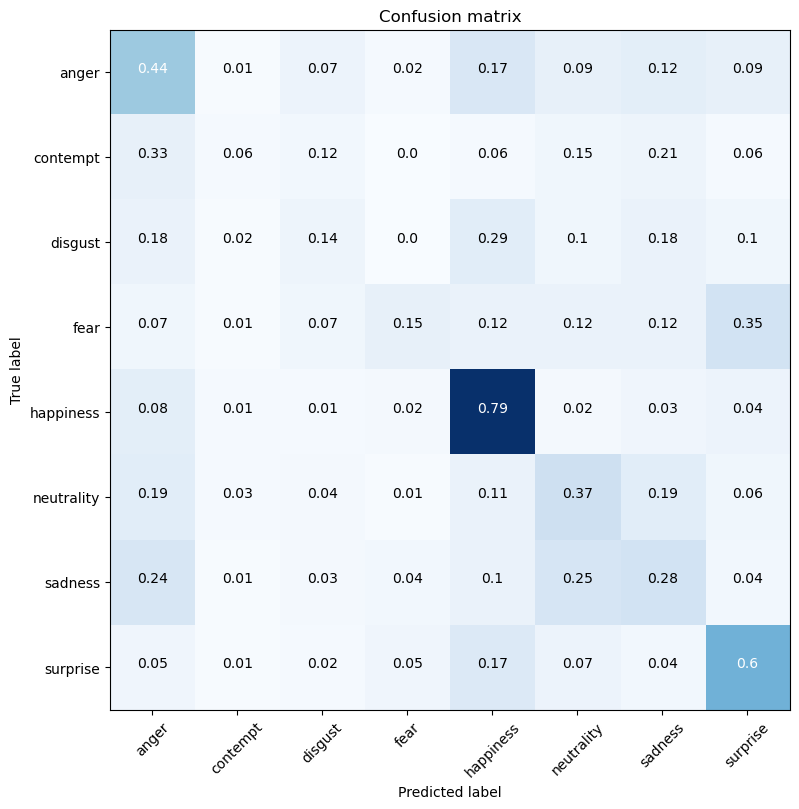

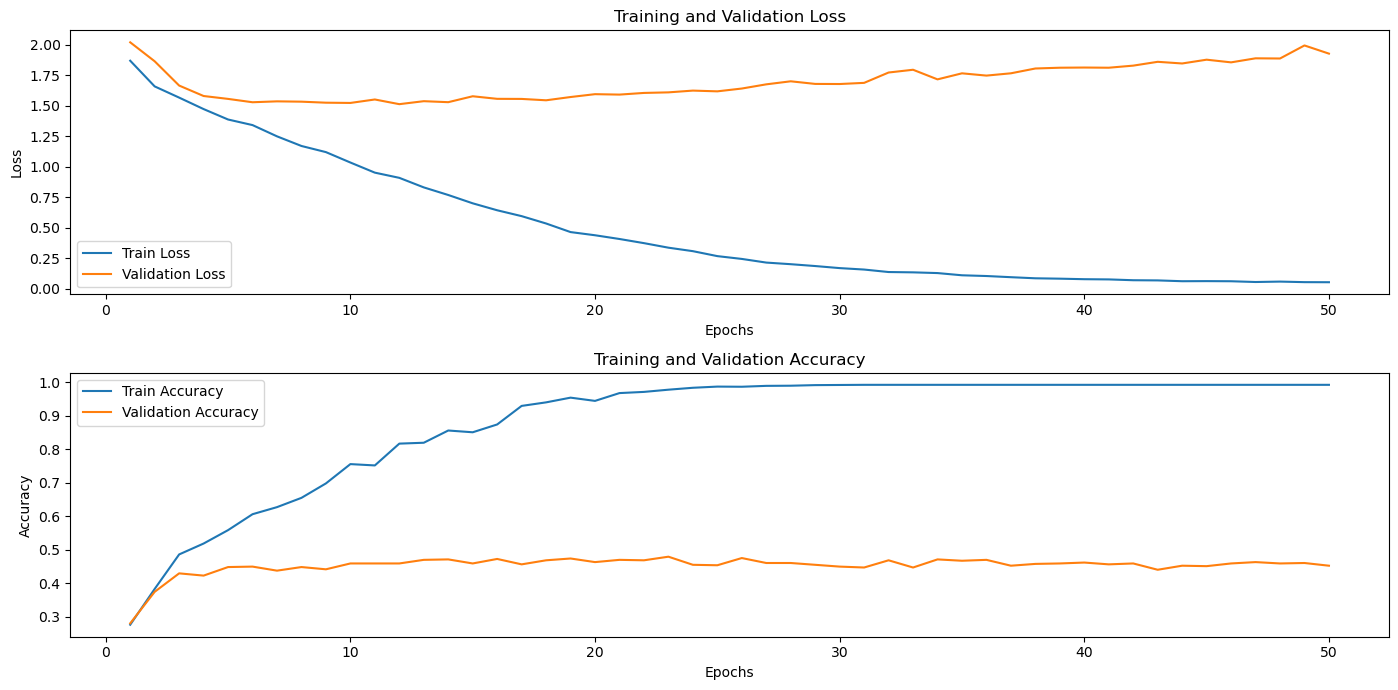

In [ ]:
use_cuda = True
combined_model = CNNetResidual(8)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=128, learningRate=2e-5, num_epochs=50)

Training Begin...

Epoch 1: Train Acc: 0.193904, Train Loss: 1.943090 | Val Acc: 0.170543, Val Loss: 2.032995
Epoch 2: Train Acc: 0.406565, Train Loss: 1.754531 | Val Acc: 0.326991, Val Loss: 1.751714
Epoch 3: Train Acc: 0.467995, Train Loss: 1.663498 | Val Acc: 0.374912, Val Loss: 1.668599
Epoch 4: Train Acc: 0.505275, Train Loss: 1.585960 | Val Acc: 0.373502, Val Loss: 1.637678
Epoch 5: Train Acc: 0.543962, Train Loss: 1.492174 | Val Acc: 0.374207, Val Loss: 1.617642
Epoch 6: Train Acc: 0.536694, Train Loss: 1.413546 | Val Acc: 0.386187, Val Loss: 1.642410
Epoch 7: Train Acc: 0.608206, Train Loss: 1.338786 | Val Acc: 0.384073, Val Loss: 1.608674
Epoch 8: Train Acc: 0.635170, Train Loss: 1.266795 | Val Acc: 0.365046, Val Loss: 1.637498
Epoch 9: Train Acc: 0.665651, Train Loss: 1.184726 | Val Acc: 0.389006, Val Loss: 1.574186
Epoch 10: Train Acc: 0.736225, Train Loss: 1.115832 | Val Acc: 0.394644, Val Loss: 1.581924
Epoch 11: Train Acc: 0.779132, Train Loss: 1.034757 | Val Acc: 0.40592

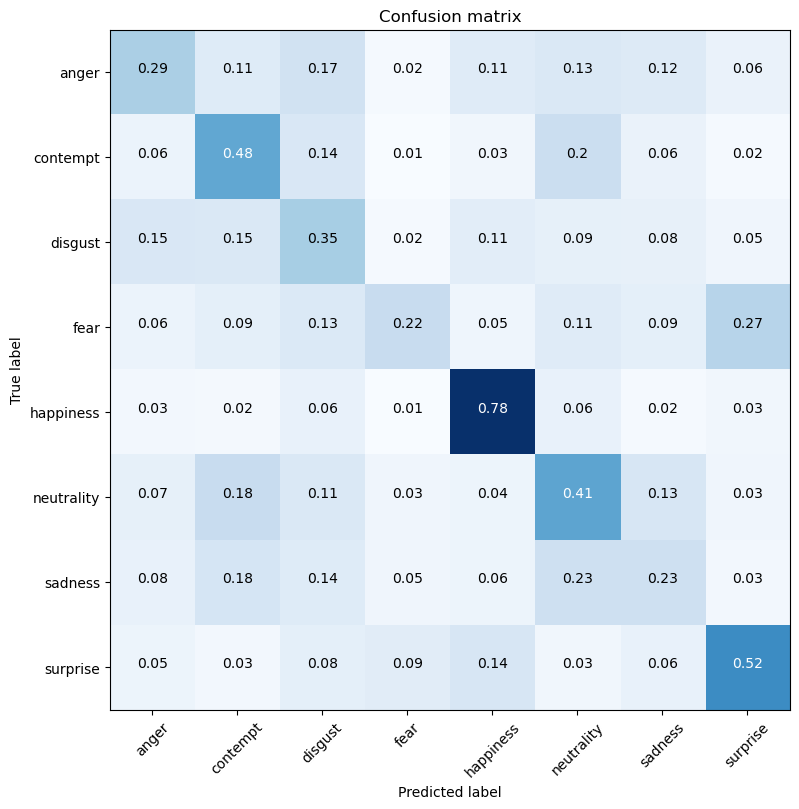

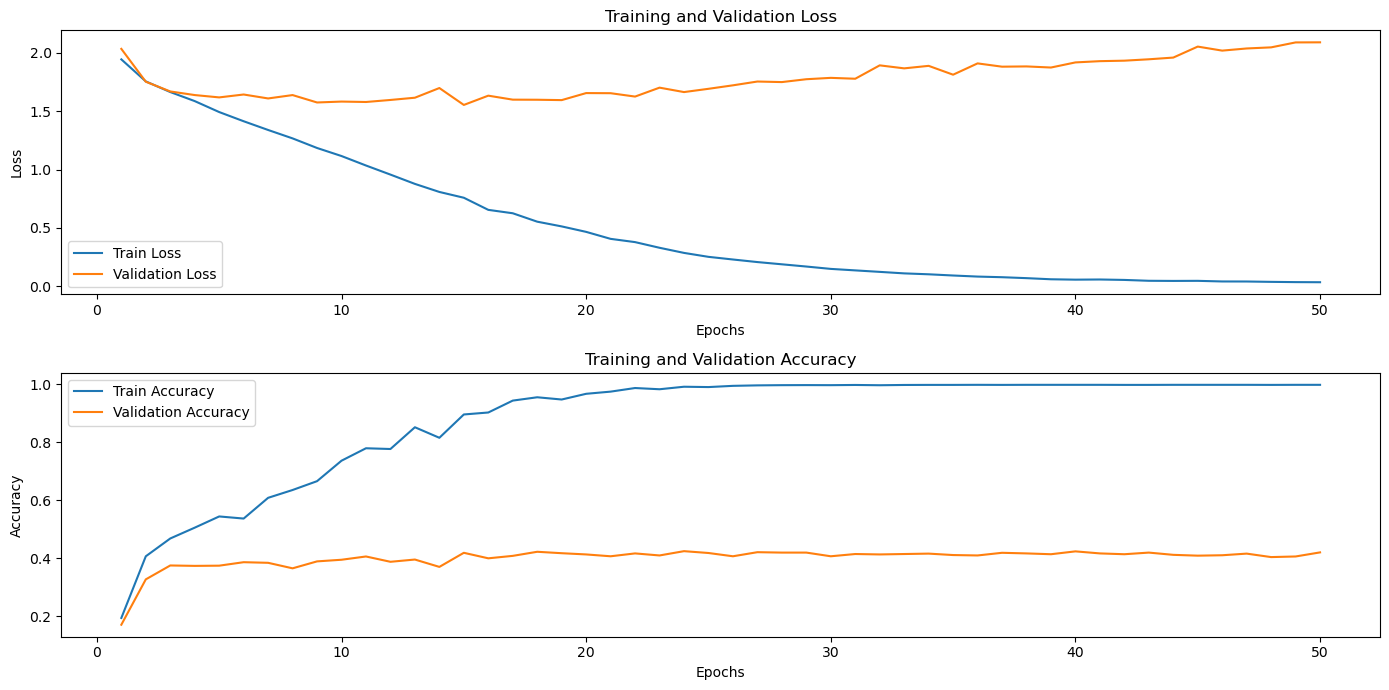

In [16]:
use_cuda = True
combined_model = CNNetResidual(8)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=128, learningRate=2e-5, num_epochs=50)

Training Begin...

Epoch 1: Train Acc: 0.335122, Train Loss: 2.051315 | Val Acc: 0.309637, Val Loss: 1.734242
Epoch 2: Train Acc: 0.410786, Train Loss: 1.654323 | Val Acc: 0.356240, Val Loss: 1.621629
Epoch 3: Train Acc: 0.434398, Train Loss: 1.575195 | Val Acc: 0.387836, Val Loss: 1.532884
Epoch 4: Train Acc: 0.469010, Train Loss: 1.515987 | Val Acc: 0.405213, Val Loss: 1.502640
Epoch 5: Train Acc: 0.472766, Train Loss: 1.477810 | Val Acc: 0.391785, Val Loss: 1.490711
Epoch 6: Train Acc: 0.497451, Train Loss: 1.429556 | Val Acc: 0.410742, Val Loss: 1.457005
Epoch 7: Train Acc: 0.499329, Train Loss: 1.388838 | Val Acc: 0.413112, Val Loss: 1.464348
Epoch 8: Train Acc: 0.546284, Train Loss: 1.336897 | Val Acc: 0.448657, Val Loss: 1.408419
Epoch 9: Train Acc: 0.549504, Train Loss: 1.285716 | Val Acc: 0.442338, Val Loss: 1.436828
Epoch 10: Train Acc: 0.585726, Train Loss: 1.258768 | Val Acc: 0.451027, Val Loss: 1.384858
Epoch 11: Train Acc: 0.520526, Train Loss: 1.212248 | Val Acc: 0.42259

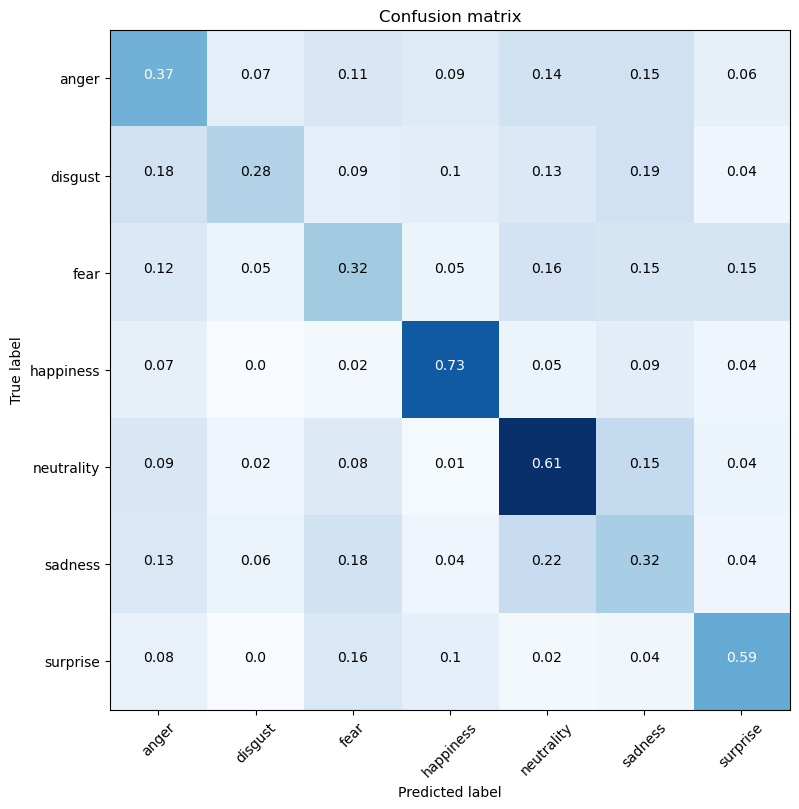

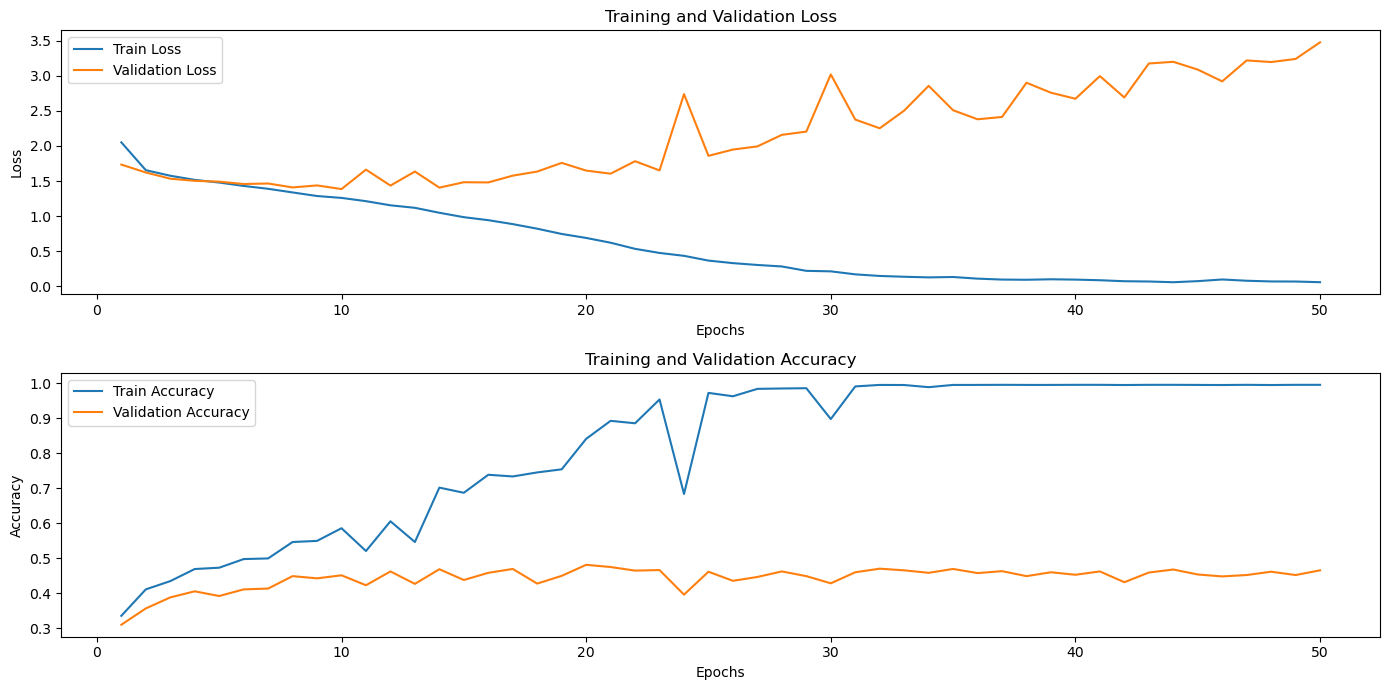

In [12]:
use_cuda = True
combined_model = CNNetResidual(7)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=64, learningRate=2e-4, num_epochs=50)

## Anger Fear Happiness Sadness

Training Begin...

Epoch 1: Train Acc: 0.384368, Train Loss: 1.227506 | Val Acc: 0.375698, Val Loss: 1.379703
Epoch 2: Train Acc: 0.568276, Train Loss: 1.037431 | Val Acc: 0.498603, Val Loss: 1.091273
Epoch 3: Train Acc: 0.625287, Train Loss: 0.967685 | Val Acc: 0.504190, Val Loss: 1.043855
Epoch 4: Train Acc: 0.659770, Train Loss: 0.912219 | Val Acc: 0.523743, Val Loss: 1.015915
Epoch 5: Train Acc: 0.677241, Train Loss: 0.849472 | Val Acc: 0.529330, Val Loss: 1.004990
Epoch 6: Train Acc: 0.748506, Train Loss: 0.801537 | Val Acc: 0.540503, Val Loss: 0.977685
Epoch 7: Train Acc: 0.770115, Train Loss: 0.730385 | Val Acc: 0.533520, Val Loss: 0.988454
Epoch 8: Train Acc: 0.821149, Train Loss: 0.687872 | Val Acc: 0.561453, Val Loss: 0.969418
Epoch 9: Train Acc: 0.830805, Train Loss: 0.613854 | Val Acc: 0.550279, Val Loss: 0.966365
Epoch 10: Train Acc: 0.860230, Train Loss: 0.574841 | Val Acc: 0.562849, Val Loss: 0.962260
Epoch 11: Train Acc: 0.881379, Train Loss: 0.523633 | Val Acc: 0.55865

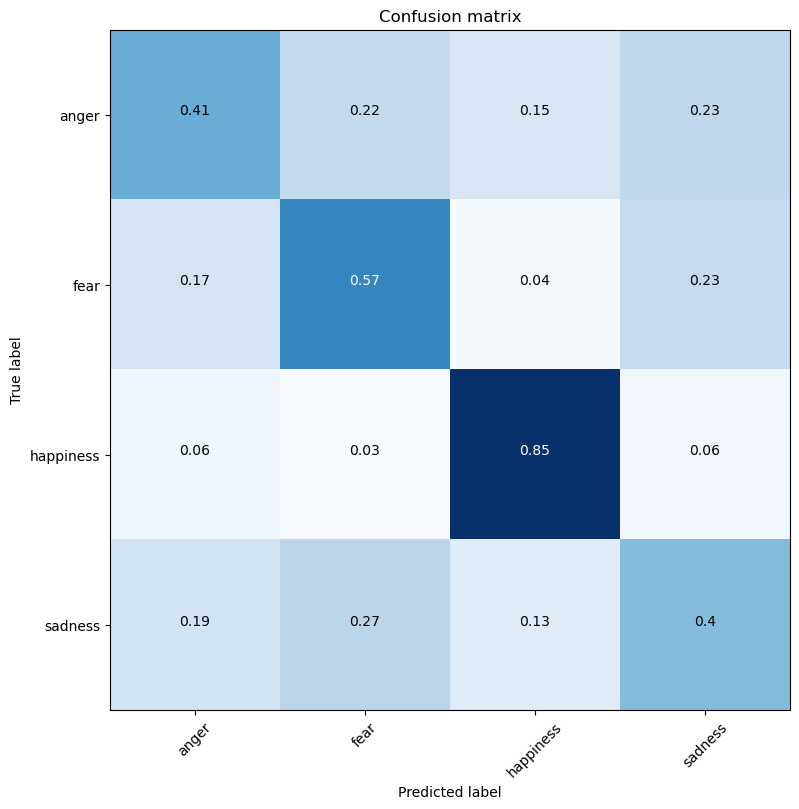

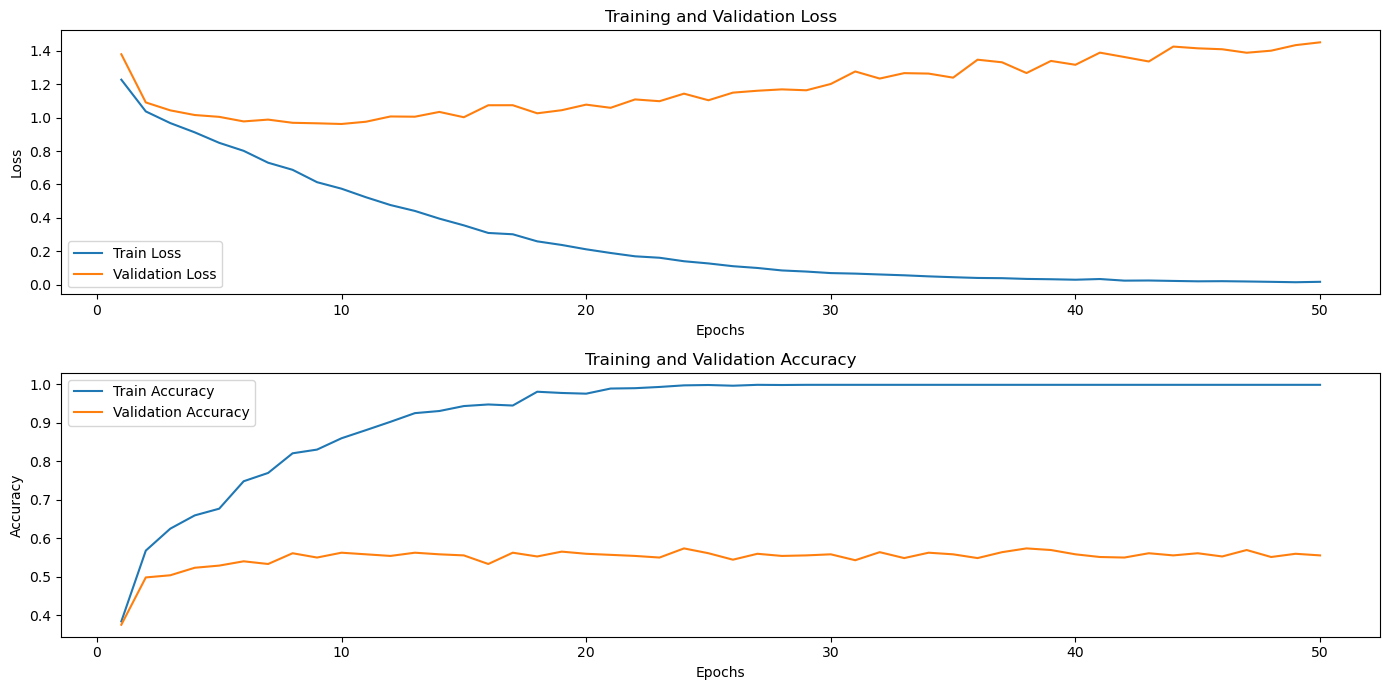

In [35]:
use_cuda = True
combined_model = CNNetResidual(4)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=64, learningRate=2e-5, num_epochs=50)

## Happiness Surprise

Training Begin...

Epoch 1: Train Acc: 0.762156, Train Loss: 0.540645 | Val Acc: 0.728707, Val Loss: 0.661263
Epoch 2: Train Acc: 0.873150, Train Loss: 0.380345 | Val Acc: 0.772871, Val Loss: 0.570288
Epoch 3: Train Acc: 0.896406, Train Loss: 0.321730 | Val Acc: 0.801262, Val Loss: 0.457815
Epoch 4: Train Acc: 0.913319, Train Loss: 0.310580 | Val Acc: 0.791798, Val Loss: 0.412476
Epoch 5: Train Acc: 0.936575, Train Loss: 0.260569 | Val Acc: 0.817035, Val Loss: 0.394043
Epoch 6: Train Acc: 0.941860, Train Loss: 0.212840 | Val Acc: 0.810726, Val Loss: 0.400633
Epoch 7: Train Acc: 0.957717, Train Loss: 0.197956 | Val Acc: 0.813880, Val Loss: 0.395556
Epoch 8: Train Acc: 0.957717, Train Loss: 0.168865 | Val Acc: 0.845426, Val Loss: 0.385404
Epoch 9: Train Acc: 0.974630, Train Loss: 0.159410 | Val Acc: 0.823344, Val Loss: 0.395330
Epoch 10: Train Acc: 0.980973, Train Loss: 0.118578 | Val Acc: 0.848580, Val Loss: 0.401277
Epoch 11: Train Acc: 0.984144, Train Loss: 0.098231 | Val Acc: 0.81072

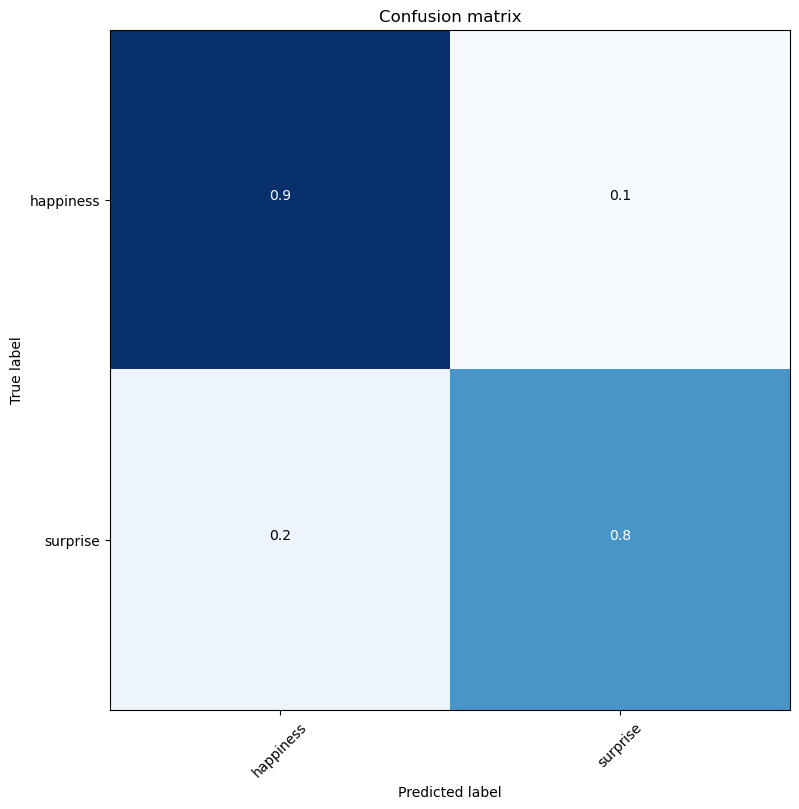

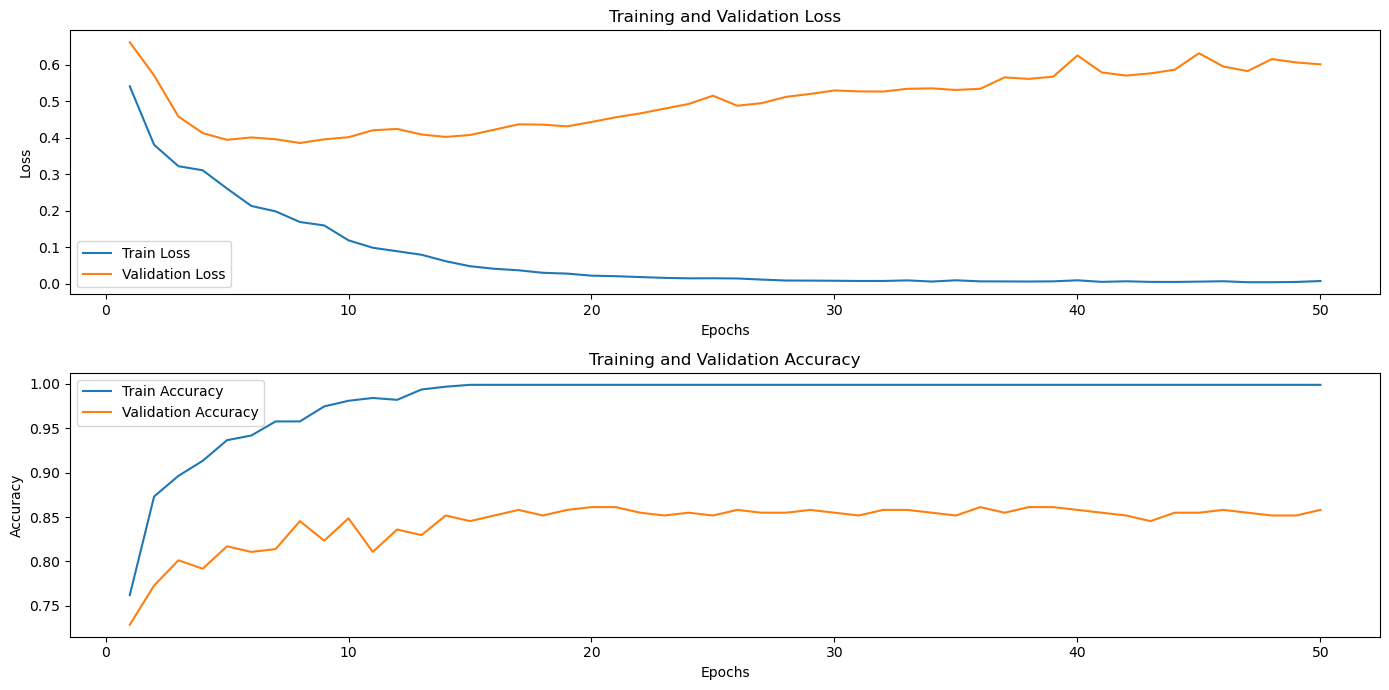

In [19]:
use_cuda = True
combined_model = CNNetResidual(2)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=64, learningRate=2e-5, num_epochs=50)

## Happiness Sadness

Training Begin...

Epoch 1: Train Acc: 0.473389, Train Loss: 0.538278 | Val Acc: 0.524540, Val Loss: 0.735614
Epoch 2: Train Acc: 0.473389, Train Loss: 0.345630 | Val Acc: 0.524540, Val Loss: 1.221002
Epoch 3: Train Acc: 0.563025, Train Loss: 0.315596 | Val Acc: 0.607362, Val Loss: 0.691682
Epoch 4: Train Acc: 0.820728, Train Loss: 0.275625 | Val Acc: 0.809816, Val Loss: 0.393283
Epoch 5: Train Acc: 0.923436, Train Loss: 0.248664 | Val Acc: 0.849693, Val Loss: 0.281859
Epoch 6: Train Acc: 0.946779, Train Loss: 0.213261 | Val Acc: 0.858896, Val Loss: 0.288335
Epoch 7: Train Acc: 0.957049, Train Loss: 0.182503 | Val Acc: 0.858896, Val Loss: 0.300209
Epoch 8: Train Acc: 0.947712, Train Loss: 0.159863 | Val Acc: 0.861963, Val Loss: 0.267239
Epoch 9: Train Acc: 0.972923, Train Loss: 0.136137 | Val Acc: 0.874233, Val Loss: 0.266858
Epoch 10: Train Acc: 0.974790, Train Loss: 0.121147 | Val Acc: 0.865031, Val Loss: 0.331814
Epoch 11: Train Acc: 0.962652, Train Loss: 0.107740 | Val Acc: 0.84969

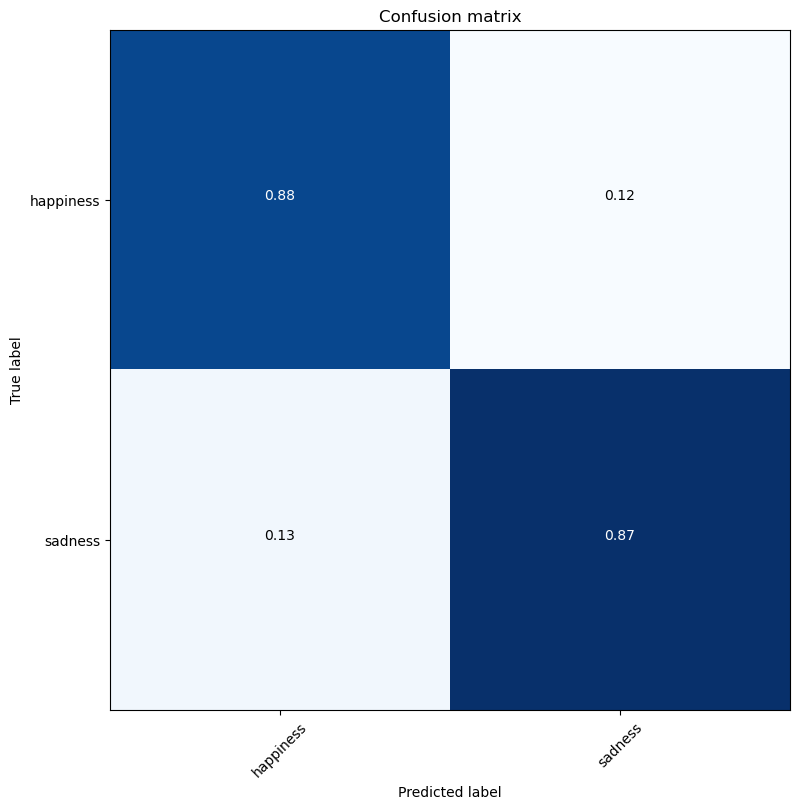

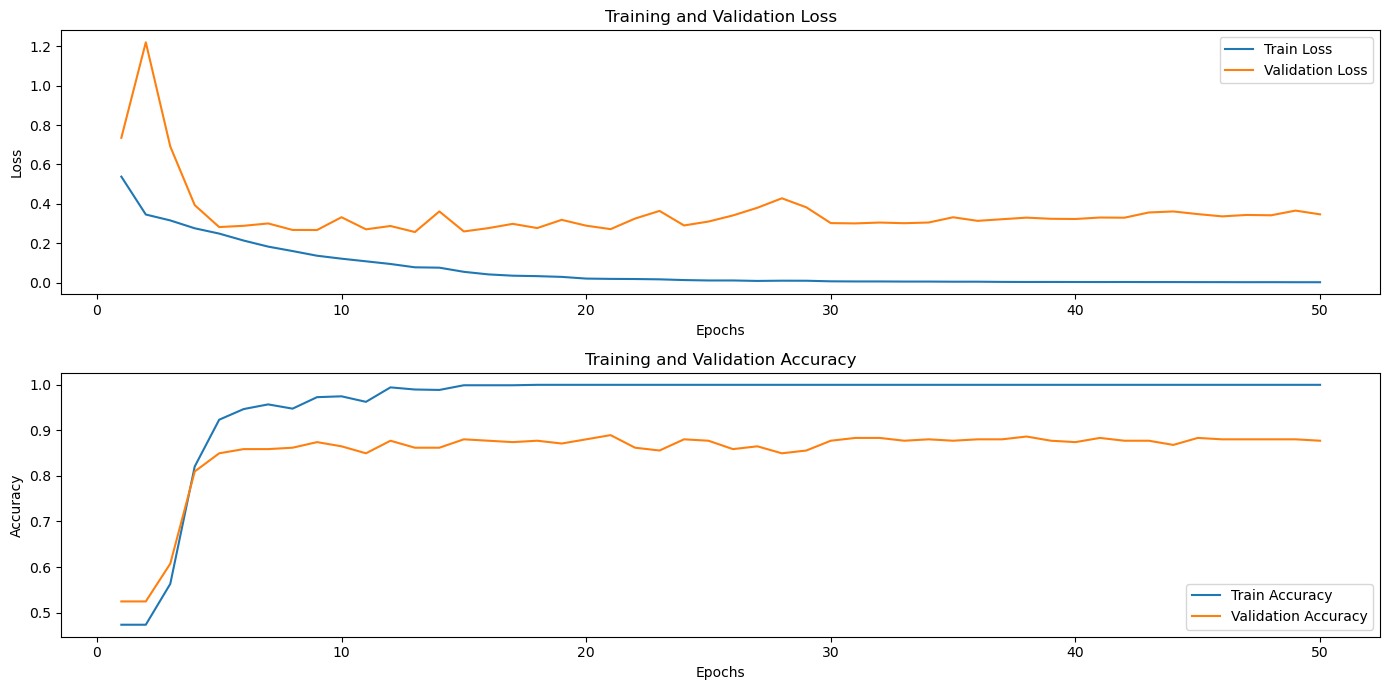

In [27]:
use_cuda = True
combined_model = CNNetResidual(2)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=64, learningRate=2e-5, num_epochs=50)

## Happiness Sadness Fear Neutrality Surprise

Training Begin...

Epoch 1: Train Acc: 0.370558, Train Loss: 1.308489 | Val Acc: 0.347392, Val Loss: 1.390452
Epoch 2: Train Acc: 0.585569, Train Loss: 1.099202 | Val Acc: 0.553829, Val Loss: 1.085728
Epoch 3: Train Acc: 0.632342, Train Loss: 1.026623 | Val Acc: 0.561598, Val Loss: 1.072024
Epoch 4: Train Acc: 0.658448, Train Loss: 0.968858 | Val Acc: 0.542730, Val Loss: 1.051294
Epoch 5: Train Acc: 0.670776, Train Loss: 0.920625 | Val Acc: 0.564928, Val Loss: 1.029858
Epoch 6: Train Acc: 0.724801, Train Loss: 0.817112 | Val Acc: 0.582686, Val Loss: 1.006459
Epoch 7: Train Acc: 0.741117, Train Loss: 0.786292 | Val Acc: 0.572697, Val Loss: 1.014139
Epoch 8: Train Acc: 0.787527, Train Loss: 0.722956 | Val Acc: 0.587125, Val Loss: 0.993686
Epoch 9: Train Acc: 0.767585, Train Loss: 0.664720 | Val Acc: 0.582686, Val Loss: 1.015121
Epoch 10: Train Acc: 0.857868, Train Loss: 0.644454 | Val Acc: 0.591565, Val Loss: 0.953162
Epoch 11: Train Acc: 0.872009, Train Loss: 0.586429 | Val Acc: 0.60821

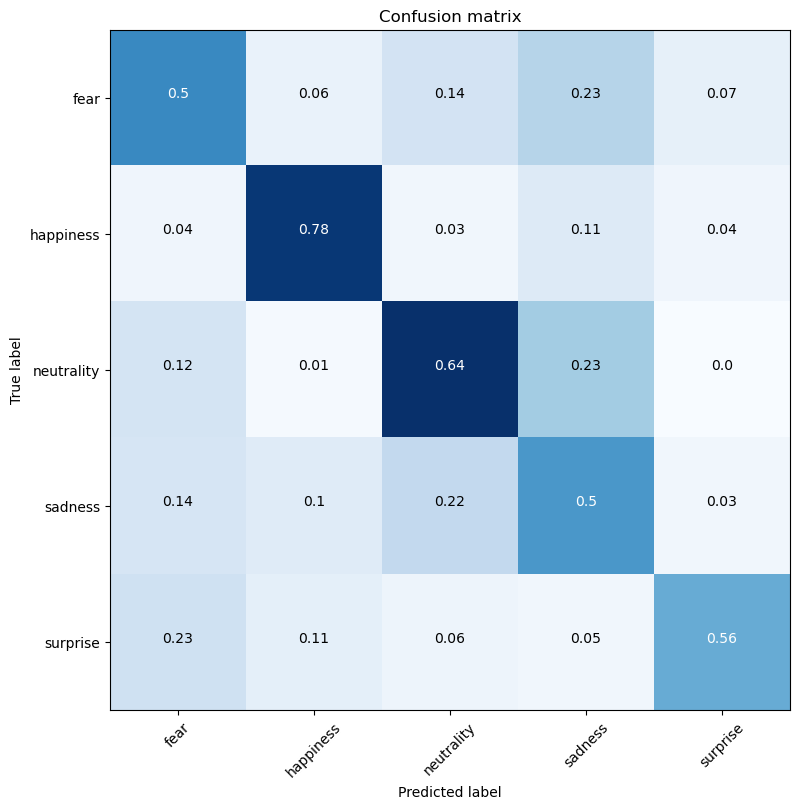

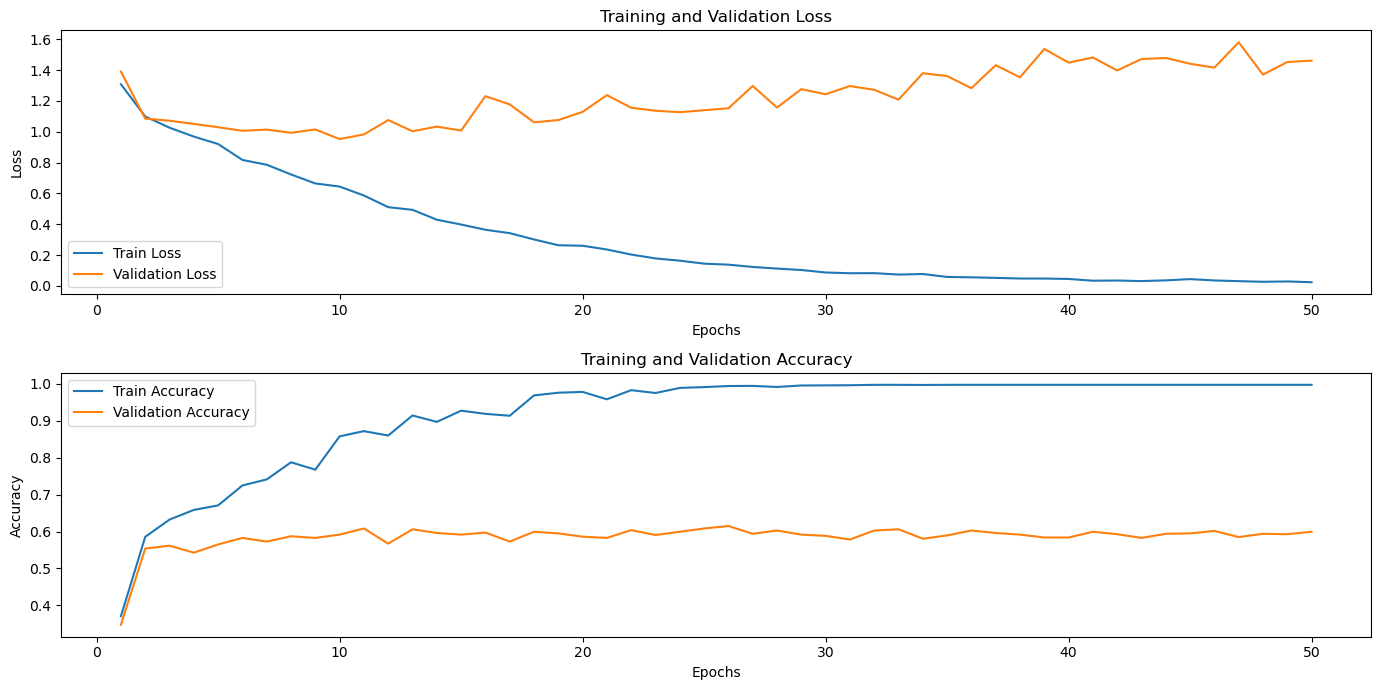

In [43]:
use_cuda = True
combined_model = CNNetResidual(5)
combined_model = combined_model.cuda()
Model1 = trainmodel(combined_model, train_dataset, val_dataset, batch=64, learningRate=2e-5, num_epochs=50)